<a href="https://colab.research.google.com/github/PhilipMathieu/access/blob/main/portland_greenspace_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary libraries
!pip install --upgrade geopandas contextily osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
import urllib.parse
import os.path
import contextily as cx

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)

## Set Boundary

Load a shapefile containing the boundary of the city of Portland, ME. This will be used to determine which Census tracts to include.

In [3]:
portland_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=3857&f=json")

## Load census tracts

In [4]:
!mkdir -p data
!wget -nc https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_23_tract.zip -P data/

File ‘data/tl_2022_23_tract.zip’ already there; not retrieving.



In [5]:
tracts = gpd.read_file("data/tl_2022_23_tract.zip").set_index('GEOID').to_crs('EPSG:3857').clip(portland_boundary)

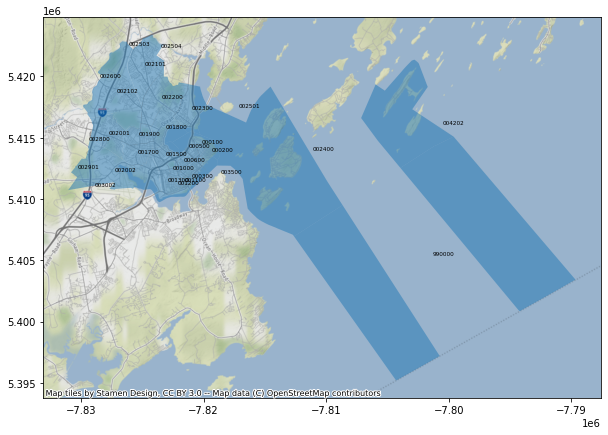

In [6]:
ax = tracts.plot(alpha=0.5)
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})
cx.add_basemap(ax)

Because this approach assumes walking distance, results aren't valid for islands. For the time being, we can accomodate this by manually removing the islands.

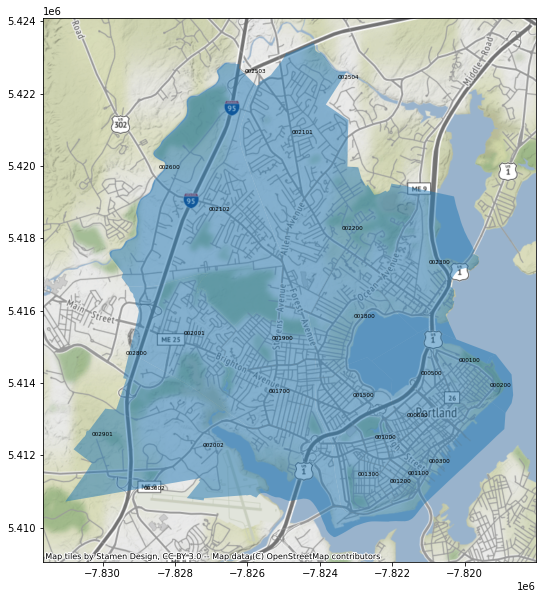

In [7]:
# manually remove islands
tracts = tracts.drop(['23005990000', '23005004202', '23005002400', '23005003500', '23005002501'])
ax = tracts.plot(alpha=0.5)
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})
cx.add_basemap(ax)

## Download and prep the street network

This is usually the most time-consuming step, as the size of the graph could be arbitrarily large. To speed up computation, download the graph separately and load it from local storage.

In [8]:
filepath = "./data/greater_portland.graphml"

if os.path.isfile(filepath):
  # load from file
  G = ox.load_graphml(filepath)
else:
  # download the street network
  bbox = tracts.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
  buffer = 0.05 # unit is lat/lon degrees
  network_type = "walk"
  G = ox.graph_from_bbox(bbox[3]+buffer, bbox[1]-buffer, bbox[2]+buffer, bbox[0]-buffer, network_type=network_type)
  G = ox.project_graph(G, 'EPSG:3857') # project the graph to UTM for this zone
  ox.save_graphml(G, filepath)

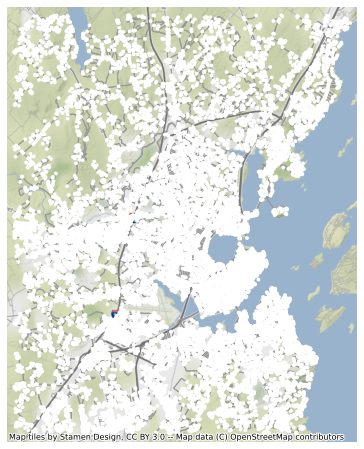

In [9]:
fig, ax = ox.plot_graph(G, bgcolor=None, show=False, close=False)
cx.add_basemap(ax)

For each census tract, we need to find the closest node on the graph. (This will allow us to compute distance entirely in terms of graph distance, as opposed to relying on spatial projections which are both slower and possibly less accurate.)

Median Distance:  72 m


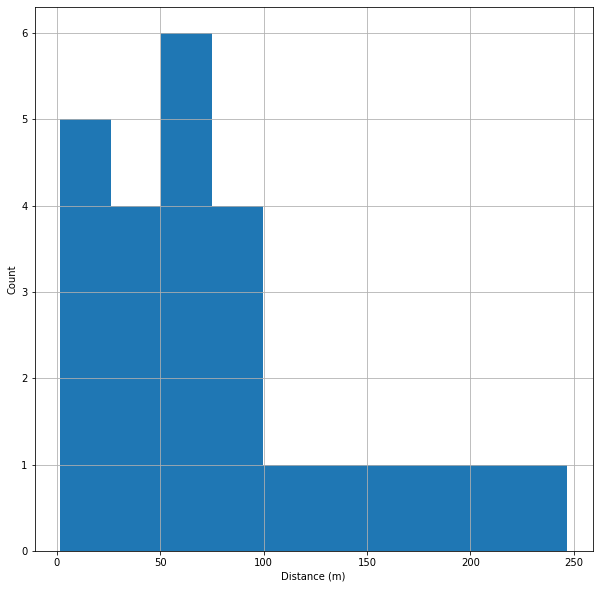

In [10]:
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids]
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

# verify that nodes are reasonably close
dists = center_nodes_gdf.distance(tracts.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} m".format(dists.median()))

## Plot nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, 30, 45, and 60 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [11]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [12]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [13]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Plotting node 101625302


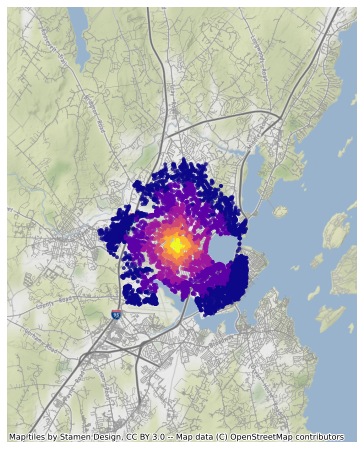

In [14]:
center_node = center_nodes[18]
print("Plotting node {}".format(center_node))
# color the nodes according to isochrone then plot the street network
node_times = {}
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_times[node] = trip_time
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",show=False, close=False
)
cx.add_basemap(ax)

## Plot the time-distances as isochrones

Rather than just labelling the nodes by walk time, it's convenient to generate convex polygons that approximate the area within each walk time. This will facilitate spatial analysis later on.

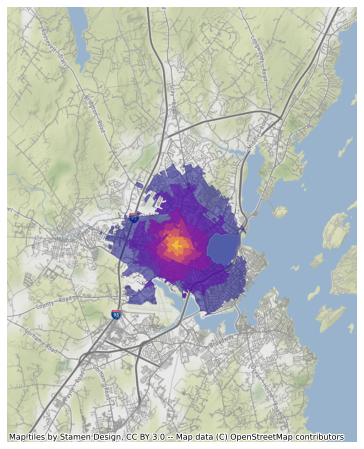

In [15]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame.from_dict({"trip_times":trip_times, "geometry":isochrone_polys}, crs="EPSG:3857")

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, bgcolor=None, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.5)
cx.add_basemap(ax)
plt.show()

## Load Conserved Lands based on bounding box
The next step is to use the walk time polygons to find conserved lands within each walk time. We start by getting all conserved lands in and near our isochrones.

In [16]:
# make an ESRI geometry JSON object from the bounding box
# https://developers.arcgis.com/rest/services-reference/enterprise/query-map-service-layer-.htm
bbox_json = json.dumps({"points":gdf.geometry.unary_union.envelope.exterior.coords[:]})
bbox_json

'{"points": [[-7830699.680182039, 5410244.126363409], [-7820426.550868578, 5410244.126363409], [-7820426.550868578, 5421119.13876639], [-7830699.680182039, 5421119.13876639], [-7830699.680182039, 5410244.126363409]]}'

In [17]:
# get all conserved parcels within 3 mile radius of this polygon
lands = gpd.read_file("https://gis.maine.gov/arcgis/rest/services/acf/Conserved_Lands/MapServer/0/query?"+
                      "where=&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry="+
                      urllib.parse.quote(bbox_json)+
                      "&geometryType=esriGeometryMultipoint&inSR=3857&spatialRel=esriSpatialRelEnvelopeIntersects&"+
                      "distance="+str(3)+"&units=esriSRUnit_StatuteMile&outFields=*&returnGeometry=true&returnTrueCurves=false&outSR=3857&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson")
ax = lands.plot(color='g')
cx.add_basemap(ax)

HTTPError: ignored

## Identify Conserved Lands within Isochrones
Here again we map each land to its centroid, then each centroid to the nearest graph node.

In [ ]:
# find conserved land centroids
centroids_cl = [point.xy for point in lands.centroid]
# Find the nearest node to the centroid
center_nodes_cl = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids_cl]
center_nodes_cl_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes_cl]

In [ ]:
# verify that nodes are reasonably close
dists = center_nodes_cl_gdf.distance(lands.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} m".format(dists.median()))

In [ ]:
# create a dataframe with the points
times = [node_times[node] if node in node_times else None for node in center_nodes_cl]
lands_points = lands.copy()
lands_points["geometry"] = center_nodes_cl_gdf.reset_index()["geometry"]
lands_points["trip_times"] = times
lands_colors = [node_colors[node] if node in node_colors else "none" for node in center_nodes_cl]

How many conserved lands are within each trip time?

In [ ]:
# calculate the number of lands within each trip time
lands_points.groupby("trip_times")["OBJECTID"].count()

What area of conserved land is within each trip time?

In [ ]:
lands_points.groupby("trip_times")["CALC_AC"].sum()

Where are the different properties on the map?

In [ ]:
# plot the network then add isochrones as colored polygon patches
fig, ax = plt.subplots()
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.2)
lands_points.plot(ax=ax, color=lands_colors)
cx.add_basemap(ax)
plt.show()

List the properties by walk time

In [ ]:
lands_points.sort_values("trip_times")